In [8]:
from IPython.display import HTML

HTML('''
<style>
.container {
    width: 70% !important;
    max-width: 70% !important;
}
</style>
''')


In [12]:
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import torch
import numpy as np
import pandas as pd
import torch.optim as optim
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, accuracy_score, roc_auc_score, recall_score, precision_score, f1_score

# GPU 선택 및 Mixed Precision 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# GPU 정보 확인
if torch.cuda.is_available():
    print(f"GPU 이름: {torch.cuda.get_device_name(0)}")
    print(f"GPU 메모리: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
    print(f"현재 GPU 메모리 사용량: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB")
    
# Mixed Precision Training을 위한 GradScaler
from torch.cuda.amp import GradScaler, autocast
scaler = GradScaler()
print("Mixed Precision Training 활성화 (속도 향상)")

# 성능 최적화 설정
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True
print("CUDNN 벤치마크 및 TF32 활성화")

Using device: cuda:0
GPU 이름: NVIDIA GeForce RTX 3090
GPU 메모리: 23.69 GB
현재 GPU 메모리 사용량: 0.02 GB
Mixed Precision Training 활성화 (속도 향상)
CUDNN 벤치마크 및 TF32 활성화


/tmp/ipykernel_15960/230922641.py:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [13]:
# 데이터 로드 - 새로 생성된 오토인코더 Bag 파일 사용
train_bags = pd.read_pickle("/workspace/MIL/data/processed/bags/train_bags_autoencoder_128d.pkl")
val_bags = pd.read_pickle("/workspace/MIL/data/processed/bags/val_bags_autoencoder_128d.pkl")
test_bags = pd.read_pickle("/workspace/MIL/data/processed/bags/test_bags_autoencoder_128d.pkl")

print(f"Train bags 로드 완료: {len(train_bags)}")
print(f"Val bags 로드 완료: {len(val_bags)}")
print(f"Test bags 로드 완료: {len(test_bags)}")

# 클래스 균형 검증
train_false = len(train_bags[train_bags['label'] == False])
train_true = len(train_bags[train_bags['label'] == True])
print(f"\n=== 클래스 분포 확인 ===")
print(f"Train - False: {train_false}, True: {train_true}, 비율: {train_false/train_true:.2f}")
print(f"Val - False: {len(val_bags[val_bags['label'] == False])}, True: {len(val_bags[val_bags['label'] == True])}")
print(f"Test - False: {len(test_bags[test_bags['label'] == False])}, True: {len(test_bags[test_bags['label'] == True])}")

# 데이터 무결성 확인
print(f"\n=== 데이터 무결성 확인 ===")
print(f"Train 첫 번째 bag features 차원: {len(train_bags.iloc[0]['features'][0])}")
print(f"예상 차원: 128 (맞아야 함)")

train_bags.head()

Train bags 로드 완료: 4320
Val bags 로드 완료: 1440
Test bags 로드 완료: 1440

=== 클래스 분포 확인 ===
Train - False: 1080, True: 3240, 비율: 0.33
Val - False: 360, True: 1080
Test - False: 360, True: 1080

=== 데이터 무결성 확인 ===
Train 첫 번째 bag features 차원: 128
예상 차원: 128 (맞아야 함)


,bag_id,label,metadata,features
0,False_200_1,False,"{'label': 200, 'repeat': 1, 'bag_size': 47, 'o...","[[0.4632517, 0.48108214, 1.062095, -0.36794165..."
1,False_201_1,False,"{'label': 201, 'repeat': 1, 'bag_size': 55, 'o...","[[-0.34756705, -2.9185777, 0.29297364, -1.0191..."
2,False_202_1,False,"{'label': 202, 'repeat': 1, 'bag_size': 56, 'o...","[[0.21132542, 2.1852295, 0.583949, -0.5527929,..."
3,False_203_1,False,"{'label': 203, 'repeat': 1, 'bag_size': 56, 'o...","[[2.0932672, -1.7507771, 2.584918, -0.8823181,..."
4,False_204_1,False,"{'label': 204, 'repeat': 1, 'bag_size': 52, 'o...","[[1.2001138, -0.65499663, -0.39570862, -0.5471..."


In [14]:
# 데이터 구조 확인
print(f"Train bags 개수: {len(train_bags)}")
print(f"컬럼: {train_bags.columns.tolist()}")
print("\n샘플 데이터:")
train_bags.iloc[0]

Train bags 개수: 4320
컬럼: ['bag_id', 'label', 'metadata', 'features']

샘플 데이터:


bag_id                                            False_200_1
label                                                   False
metadata    {'label': 200, 'repeat': 1, 'bag_size': 47, 'o...
features    [[0.4632517, 0.48108214, 1.062095, -0.36794165...
Name: 0, dtype: object

In [15]:
# 첫 번째 bag의 features 확인
if len(train_bags) > 0:
    first_bag = train_bags.iloc[0]
    print(f"Bag ID: {first_bag['bag_id']}")
    print(f"Label: {first_bag['label']}")
    print(f"Features shape: {len(first_bag['features'])} x {len(first_bag['features'][0])}")
    print(f"\nMetadata:")
    print(first_bag['metadata'])
    
    # Features를 DataFrame으로 변환
    features_df = pd.DataFrame(first_bag['features'])
    print(f"\nFeatures DataFrame shape: {features_df.shape}")
    features_df.head()

Bag ID: False_200_1
Label: False
Features shape: 47 x 128

Metadata:
{'label': 200, 'repeat': 1, 'bag_size': 47, 'original_indices': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]}

Features DataFrame shape: (47, 128)


In [16]:
# Custom Dataset 정의
class MILDataset(Dataset):
    def __init__(self, bags, max_instances=75):
        self.bags = bags
        self.max_instances = max_instances

    def __len__(self):
        return len(self.bags)

    def __getitem__(self, idx):
        bag = self.bags.iloc[idx]
        features = torch.tensor(bag['features'], dtype=torch.float32)  # Feature 텐서
        
        # Label 변환 - Boolean False/True를 0/1로 변환
        label = 1.0 if bag['label'] == True else 0.0
        label = torch.tensor(label, dtype=torch.float32)  # Bag Label

        # Bag의 길이를 고정
        if features.size(0) > self.max_instances:
            features = features[:self.max_instances]  # 최대 길이만큼 자름
        else:
            # 패딩 추가 (길이가 부족한 경우)
            padding = torch.zeros(self.max_instances - features.size(0), features.size(1))
            features = torch.cat([features, padding], dim=0)

        return features, label

# Dataset 생성
train_dataset = MILDataset(train_bags, max_instances=75)
val_dataset = MILDataset(val_bags, max_instances=75)
test_dataset = MILDataset(test_bags, max_instances=75)

# 레이블 분포 확인
train_labels = [1 if bag['label'] == True else 0 for _, bag in train_bags.iterrows()]
print(f"Train 레이블 분포 - False: {train_labels.count(0)}, True: {train_labels.count(1)}")
print(f"클래스 비율 - True/Total: {train_labels.count(1)/len(train_labels):.2%}")

# DataLoader 생성 - 자원 최대 활용
# RTX 3090 24GB 기준 배치 크기 증가 및 멀티프로세싱 활용
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, 
                         num_workers=16, pin_memory=True, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False,
                       num_workers=16, pin_memory=True, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False,
                        num_workers=16, pin_memory=True, persistent_workers=True)

print(f"배치 크기: 128 (RTX 3090 최적화)")
print(f"데이터 로더 워커: 16개 (CPU 코어 활용)")
print(f"Pin memory 활성화 (GPU 전송 속도 향상)")

Train 레이블 분포 - False: 1080, True: 3240
클래스 비율 - True/Total: 75.00%
배치 크기: 128 (RTX 3090 최적화)
데이터 로더 워커: 16개 (CPU 코어 활용)
Pin memory 활성화 (GPU 전송 속도 향상)


In [17]:
class ABMILModel(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(ABMILModel, self).__init__()
        self.attention = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )
        self.classifier = nn.Linear(input_dim, 1)

    def forward(self, x):
        # x: (batch_size, num_instances, input_dim)
        attention_weights = torch.softmax(self.attention(x), dim=1)  # Attention weights
        bag_representation = torch.sum(attention_weights * x, dim=1)  # Weighted sum
        output = self.classifier(bag_representation)  # Final classification
        return output, attention_weights

In [18]:
class EarlyStopping:
    def __init__(self, save_path, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_loss = np.Inf
        self.counter = 0
        self.early_stop = False
        self.save_path = save_path

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
            # Best 모델 저장
            torch.save(model.state_dict(), self.save_path)
            if self.verbose:
                print(f"Validation loss improved to {val_loss:.4f}. Model saved to {self.save_path}.")
        else:
            self.counter += 1
            if self.verbose:
                print(f"Validation loss did not improve for {self.counter} epochs.")
            if self.counter >= self.patience:
                self.early_stop = True

In [19]:
def evaluate_model(model, test_loader, device, save_dir=None):
    model.eval()  # 모델 평가 모드
    all_labels = []
    all_predictions = []
    all_probs = []  # AUC 계산을 위한 확률 값
    all_logits = []  # Logits 저장

    with torch.no_grad():
        for features, labels in tqdm(test_loader, desc="Evaluating Test Data"):
            features, labels = features.to(device), labels.to(device)

            # Forward pass
            outputs, _ = model(features)
            logits = outputs.squeeze()  # Logits 값
            probs = torch.sigmoid(logits)  # 확률값
            predictions = torch.round(probs)  # 0.5 기준으로 이진 분류

            # 데이터 저장
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_logits.extend(logits.cpu().numpy())

    # 성능 지표 계산
    accuracy = accuracy_score(all_labels, all_predictions)
    auc_score = roc_auc_score(all_labels, all_probs)
    recall = recall_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)

    # 결과 출력
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test AUC: {auc_score:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test F1-Score: {f1:.4f}")

    # 저장 디렉토리 설정
    if save_dir is None:
        save_dir = "/workspace/MIL/output/figures"
    os.makedirs(save_dir, exist_ok=True)
    
    # ROC Curve 그리기
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.grid()
    
    # ROC 곡선 저장
    roc_path = os.path.join(save_dir, f"{model_name}_roc_curve.png")
    plt.savefig(roc_path, dpi=300, bbox_inches='tight')
    print(f"ROC 곡선 저장: {roc_path}")
    plt.show()

    # Logits 분포 그리기
    true_logits = [logit for logit, label in zip(all_logits, all_labels) if label == 1]
    false_logits = [logit for logit, label in zip(all_logits, all_labels) if label == 0]

    plt.figure(figsize=(10, 6))
    plt.hist(true_logits, bins=30, alpha=0.7, label='True Labels', color='blue')
    plt.hist(false_logits, bins=30, alpha=0.7, label='False Labels', color='red')
    plt.xlabel('Logits')
    plt.ylabel('Frequency')
    plt.title('Logits Distribution by Label')
    plt.legend(loc='upper right')
    plt.grid()
    
    # Logits 분포 저장
    logits_path = os.path.join(save_dir, f"{model_name}_logits_distribution.png")
    plt.savefig(logits_path, dpi=300, bbox_inches='tight')
    print(f"Logits 분포 저장: {logits_path}")
    plt.show()

    # Confusion Matrix 추가
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['False (0)', 'True (1)'],
                yticklabels=['False (0)', 'True (1)'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    
    # Confusion Matrix 저장
    cm_path = os.path.join(save_dir, f"{model_name}_confusion_matrix.png")
    plt.savefig(cm_path, dpi=300, bbox_inches='tight')
    print(f"Confusion Matrix 저장: {cm_path}")
    plt.show()

    # 결과를 JSON으로 저장
    import json
    results = {
        "accuracy": float(accuracy),
        "auc": float(auc_score),
        "recall": float(recall),
        "precision": float(precision),
        "f1": float(f1),
        "confusion_matrix": cm.tolist()
    }
    
    results_dir = "/workspace/MIL/output/results"
    os.makedirs(results_dir, exist_ok=True)
    results_path = os.path.join(results_dir, f"{model_name}_results.json")
    
    with open(results_path, 'w') as f:
        json.dump(results, f, indent=4)
    print(f"결과 저장: {results_path}")

    return results

In [20]:
# 모델 초기화
input_dim = 128  # Feature dimension
hidden_dim = 64  # Hidden dimension for attention
model = ABMILModel(input_dim, hidden_dim).to(device)

# 클래스 불균형 해결을 위한 가중치 계산
# 현재 데이터: False 25%, True 75% → True 클래스가 3배 많음
# 따라서 False 클래스에 3배 가중치 부여
pos_weight = torch.tensor([3.0]).to(device)  # True 클래스 가중치
print(f"클래스 가중치 적용: pos_weight = {pos_weight.item()}")

# 손실 함수 - 클래스 가중치 적용
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
print("BCEWithLogitsLoss에 클래스 가중치 적용 완료")

# 옵티마이저 - 학습률 조정
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # 더 낮은 학습률
print(f"Optimizer: Adam with lr=0.0001")

# 모델명을 새로 생성된 데이터에 맞게 수정
model_name = 'ab_mil_autoencoder_128d_balanced'  # balanced 추가
save_path = f"/workspace/MIL/output/models/{model_name}_best_model.pt"

# 모델 디렉토리 생성
import os
os.makedirs("/workspace/MIL/output/models", exist_ok=True)

# Early stopping 설정 - patience 증가
early_stopping = EarlyStopping(save_path=save_path, patience=10, verbose=True)

# 학습 루프
num_epochs = 100  # 에폭 수 증가

print(f"\n=== 클래스 불균형 개선 설정 ===")
print(f"모델 저장 경로: {save_path}")
print(f"Early stopping patience: 10 epochs")
print(f"최대 에폭 수: {num_epochs}")
print(f"클래스 가중치: False=1.0, True={pos_weight.item()}")

클래스 가중치 적용: pos_weight = 3.0
BCEWithLogitsLoss에 클래스 가중치 적용 완료
Optimizer: Adam with lr=0.0001

=== 클래스 불균형 개선 설정 ===
모델 저장 경로: /workspace/MIL/output/models/ab_mil_autoencoder_128d_balanced_best_model.pt
Early stopping patience: 10 epochs
최대 에폭 수: 100
클래스 가중치: False=1.0, True=3.0


/opt/conda/envs/py38/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


학습 시작 전 GPU 메모리: 0.02 GB


Epoch 1/100 [Training]:   0%|          | 0/34 [00:00<?, ?it/s]/tmp/ipykernel_15960/3934410387.py:66: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/100 [Validation]:   0%|          | 0/12 [00:00<?, ?it/s]/tmp/ipykernel_15960/3934410387.py:103: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/100 [Validation]: 100%|██████████| 12/12 [00:03<00:00,  3.85it/s]


Epoch 1/100, Train Loss: 1.3737, Train Accuracy: 0.6861, Val Loss: 0.9186, Val Accuracy: 0.7500
Validation loss improved to 0.9186. Model saved to /workspace/MIL/output/models/ab_mil_autoencoder_128d_balanced_best_model.pt.


Epoch 2/100 [Validation]: 100%|██████████| 12/12 [00:00<00:00, 68.55it/s]


Epoch 2/100, Train Loss: 0.8517, Train Accuracy: 0.7500, Val Loss: 0.7997, Val Accuracy: 0.7500
Validation loss improved to 0.7997. Model saved to /workspace/MIL/output/models/ab_mil_autoencoder_128d_balanced_best_model.pt.


Epoch 3/100 [Validation]: 100%|██████████| 12/12 [00:00<00:00, 71.99it/s]


Epoch 3/100, Train Loss: 0.8279, Train Accuracy: 0.7500, Val Loss: 0.7970, Val Accuracy: 0.7500
Validation loss improved to 0.7970. Model saved to /workspace/MIL/output/models/ab_mil_autoencoder_128d_balanced_best_model.pt.


Epoch 4/100 [Validation]: 100%|██████████| 12/12 [00:00<00:00, 76.64it/s]


Epoch 4/100, Train Loss: 0.8262, Train Accuracy: 0.7500, Val Loss: 0.7956, Val Accuracy: 0.7500
Validation loss improved to 0.7956. Model saved to /workspace/MIL/output/models/ab_mil_autoencoder_128d_balanced_best_model.pt.


Epoch 5/100 [Validation]: 100%|██████████| 12/12 [00:00<00:00, 71.06it/s]


Epoch 5/100, Train Loss: 0.8228, Train Accuracy: 0.7500, Val Loss: 0.7943, Val Accuracy: 0.7500
Validation loss improved to 0.7943. Model saved to /workspace/MIL/output/models/ab_mil_autoencoder_128d_balanced_best_model.pt.


Epoch 6/100 [Validation]: 100%|██████████| 12/12 [00:00<00:00, 77.76it/s]


Epoch 6/100, Train Loss: 0.8222, Train Accuracy: 0.7500, Val Loss: 0.7925, Val Accuracy: 0.7500
Validation loss improved to 0.7925. Model saved to /workspace/MIL/output/models/ab_mil_autoencoder_128d_balanced_best_model.pt.


Epoch 7/100 [Validation]: 100%|██████████| 12/12 [00:00<00:00, 72.81it/s]


Epoch 7/100, Train Loss: 0.8217, Train Accuracy: 0.7500, Val Loss: 0.7917, Val Accuracy: 0.7500
Validation loss improved to 0.7917. Model saved to /workspace/MIL/output/models/ab_mil_autoencoder_128d_balanced_best_model.pt.


Epoch 8/100 [Validation]: 100%|██████████| 12/12 [00:00<00:00, 59.85it/s]


Epoch 8/100, Train Loss: 0.8190, Train Accuracy: 0.7500, Val Loss: 0.7920, Val Accuracy: 0.7500
Validation loss did not improve for 1 epochs.


Epoch 9/100 [Validation]: 100%|██████████| 12/12 [00:00<00:00, 57.48it/s]


Epoch 9/100, Train Loss: 0.8193, Train Accuracy: 0.7500, Val Loss: 0.7902, Val Accuracy: 0.7500
Validation loss improved to 0.7902. Model saved to /workspace/MIL/output/models/ab_mil_autoencoder_128d_balanced_best_model.pt.


Epoch 10/100 [Validation]: 100%|██████████| 12/12 [00:00<00:00, 71.42it/s]


Epoch 10/100, Train Loss: 0.8190, Train Accuracy: 0.7500, Val Loss: 0.7897, Val Accuracy: 0.7500
Validation loss improved to 0.7897. Model saved to /workspace/MIL/output/models/ab_mil_autoencoder_128d_balanced_best_model.pt.


Epoch 11/100 [Validation]: 100%|██████████| 12/12 [00:00<00:00, 69.77it/s]


Epoch 11/100, Train Loss: 0.8166, Train Accuracy: 0.7500, Val Loss: 0.7893, Val Accuracy: 0.7500
Validation loss improved to 0.7893. Model saved to /workspace/MIL/output/models/ab_mil_autoencoder_128d_balanced_best_model.pt.


Epoch 12/100 [Validation]: 100%|██████████| 12/12 [00:00<00:00, 57.08it/s]


Epoch 12/100, Train Loss: 0.8170, Train Accuracy: 0.7500, Val Loss: 0.7894, Val Accuracy: 0.7500
Validation loss did not improve for 1 epochs.


Epoch 13/100 [Validation]: 100%|██████████| 12/12 [00:00<00:00, 71.27it/s]


Epoch 13/100, Train Loss: 0.8160, Train Accuracy: 0.7500, Val Loss: 0.7894, Val Accuracy: 0.7500
Validation loss did not improve for 2 epochs.


Epoch 14/100 [Validation]: 100%|██████████| 12/12 [00:00<00:00, 71.39it/s]


Epoch 14/100, Train Loss: 0.8158, Train Accuracy: 0.7500, Val Loss: 0.7892, Val Accuracy: 0.7500
Validation loss improved to 0.7892. Model saved to /workspace/MIL/output/models/ab_mil_autoencoder_128d_balanced_best_model.pt.


Epoch 15/100 [Validation]: 100%|██████████| 12/12 [00:00<00:00, 75.48it/s]


Epoch 15/100, Train Loss: 0.8158, Train Accuracy: 0.7500, Val Loss: 0.7881, Val Accuracy: 0.7500
Validation loss improved to 0.7881. Model saved to /workspace/MIL/output/models/ab_mil_autoencoder_128d_balanced_best_model.pt.


Epoch 16/100 [Validation]: 100%|██████████| 12/12 [00:00<00:00, 74.75it/s]


Epoch 16/100, Train Loss: 0.8153, Train Accuracy: 0.7500, Val Loss: 0.7878, Val Accuracy: 0.7500
Validation loss improved to 0.7878. Model saved to /workspace/MIL/output/models/ab_mil_autoencoder_128d_balanced_best_model.pt.


Epoch 17/100 [Validation]: 100%|██████████| 12/12 [00:00<00:00, 75.23it/s]


Epoch 17/100, Train Loss: 0.8138, Train Accuracy: 0.7500, Val Loss: 0.7886, Val Accuracy: 0.7500
Validation loss did not improve for 1 epochs.


Epoch 18/100 [Validation]: 100%|██████████| 12/12 [00:00<00:00, 75.73it/s]


Epoch 18/100, Train Loss: 0.8148, Train Accuracy: 0.7500, Val Loss: 0.7867, Val Accuracy: 0.7500
Validation loss improved to 0.7867. Model saved to /workspace/MIL/output/models/ab_mil_autoencoder_128d_balanced_best_model.pt.


Epoch 19/100 [Validation]: 100%|██████████| 12/12 [00:00<00:00, 72.00it/s]


Epoch 19/100, Train Loss: 0.8131, Train Accuracy: 0.7500, Val Loss: 0.7869, Val Accuracy: 0.7500
Validation loss did not improve for 1 epochs.


Epoch 20/100 [Validation]: 100%|██████████| 12/12 [00:00<00:00, 70.95it/s]


Epoch 20/100, Train Loss: 0.8118, Train Accuracy: 0.7500, Val Loss: 0.7866, Val Accuracy: 0.7500
Validation loss improved to 0.7866. Model saved to /workspace/MIL/output/models/ab_mil_autoencoder_128d_balanced_best_model.pt.


Epoch 21/100 [Validation]: 100%|██████████| 12/12 [00:00<00:00, 71.81it/s]


Epoch 21/100, Train Loss: 0.8118, Train Accuracy: 0.7500, Val Loss: 0.7870, Val Accuracy: 0.7500
Validation loss did not improve for 1 epochs.


Epoch 22/100 [Validation]: 100%|██████████| 12/12 [00:00<00:00, 72.83it/s]


Epoch 22/100, Train Loss: 0.8102, Train Accuracy: 0.7500, Val Loss: 0.7867, Val Accuracy: 0.7500
Validation loss did not improve for 2 epochs.


Epoch 23/100 [Validation]: 100%|██████████| 12/12 [00:00<00:00, 72.89it/s]


Epoch 23/100, Train Loss: 0.8106, Train Accuracy: 0.7500, Val Loss: 0.7862, Val Accuracy: 0.7500
Validation loss improved to 0.7862. Model saved to /workspace/MIL/output/models/ab_mil_autoencoder_128d_balanced_best_model.pt.


Epoch 24/100 [Validation]: 100%|██████████| 12/12 [00:00<00:00, 73.72it/s]


Epoch 24/100, Train Loss: 0.8092, Train Accuracy: 0.7502, Val Loss: 0.7856, Val Accuracy: 0.7500
Validation loss improved to 0.7856. Model saved to /workspace/MIL/output/models/ab_mil_autoencoder_128d_balanced_best_model.pt.


Epoch 25/100 [Validation]: 100%|██████████| 12/12 [00:00<00:00, 67.84it/s]


Epoch 25/100, Train Loss: 0.8084, Train Accuracy: 0.7502, Val Loss: 0.7861, Val Accuracy: 0.7500
Validation loss did not improve for 1 epochs.


Epoch 26/100 [Validation]: 100%|██████████| 12/12 [00:00<00:00, 77.98it/s]


Epoch 26/100, Train Loss: 0.8082, Train Accuracy: 0.7502, Val Loss: 0.7851, Val Accuracy: 0.7500
Validation loss improved to 0.7851. Model saved to /workspace/MIL/output/models/ab_mil_autoencoder_128d_balanced_best_model.pt.


Epoch 27/100 [Validation]: 100%|██████████| 12/12 [00:00<00:00, 75.01it/s]


Epoch 27/100, Train Loss: 0.8062, Train Accuracy: 0.7502, Val Loss: 0.7839, Val Accuracy: 0.7500
Validation loss improved to 0.7839. Model saved to /workspace/MIL/output/models/ab_mil_autoencoder_128d_balanced_best_model.pt.


Epoch 28/100 [Validation]: 100%|██████████| 12/12 [00:00<00:00, 74.53it/s]


Epoch 28/100, Train Loss: 0.8061, Train Accuracy: 0.7502, Val Loss: 0.7843, Val Accuracy: 0.7500
Validation loss did not improve for 1 epochs.


Epoch 29/100 [Validation]: 100%|██████████| 12/12 [00:00<00:00, 69.55it/s]


Epoch 29/100, Train Loss: 0.8057, Train Accuracy: 0.7502, Val Loss: 0.7840, Val Accuracy: 0.7500
Validation loss did not improve for 2 epochs.


Epoch 30/100 [Validation]: 100%|██████████| 12/12 [00:00<00:00, 75.73it/s]


Epoch 30/100, Train Loss: 0.8036, Train Accuracy: 0.7502, Val Loss: 0.7845, Val Accuracy: 0.7500
Validation loss did not improve for 3 epochs.


Epoch 31/100 [Validation]: 100%|██████████| 12/12 [00:00<00:00, 77.23it/s]


Epoch 31/100, Train Loss: 0.8032, Train Accuracy: 0.7502, Val Loss: 0.7831, Val Accuracy: 0.7500
Validation loss improved to 0.7831. Model saved to /workspace/MIL/output/models/ab_mil_autoencoder_128d_balanced_best_model.pt.


Epoch 32/100 [Validation]: 100%|██████████| 12/12 [00:00<00:00, 74.67it/s]


Epoch 32/100, Train Loss: 0.8020, Train Accuracy: 0.7502, Val Loss: 0.7819, Val Accuracy: 0.7500
Validation loss improved to 0.7819. Model saved to /workspace/MIL/output/models/ab_mil_autoencoder_128d_balanced_best_model.pt.


Epoch 33/100 [Validation]: 100%|██████████| 12/12 [00:00<00:00, 74.61it/s]


Epoch 33/100, Train Loss: 0.8002, Train Accuracy: 0.7502, Val Loss: 0.7835, Val Accuracy: 0.7500
Validation loss did not improve for 1 epochs.


Epoch 34/100 [Validation]: 100%|██████████| 12/12 [00:00<00:00, 70.09it/s]


Epoch 34/100, Train Loss: 0.8000, Train Accuracy: 0.7502, Val Loss: 0.7806, Val Accuracy: 0.7500
Validation loss improved to 0.7806. Model saved to /workspace/MIL/output/models/ab_mil_autoencoder_128d_balanced_best_model.pt.


Epoch 35/100 [Validation]: 100%|██████████| 12/12 [00:00<00:00, 74.07it/s]


Epoch 35/100, Train Loss: 0.8005, Train Accuracy: 0.7502, Val Loss: 0.7808, Val Accuracy: 0.7500
Validation loss did not improve for 1 epochs.


Epoch 36/100 [Validation]: 100%|██████████| 12/12 [00:00<00:00, 70.62it/s]


Epoch 36/100, Train Loss: 0.7983, Train Accuracy: 0.7502, Val Loss: 0.7802, Val Accuracy: 0.7500
Validation loss improved to 0.7802. Model saved to /workspace/MIL/output/models/ab_mil_autoencoder_128d_balanced_best_model.pt.


Epoch 37/100 [Validation]: 100%|██████████| 12/12 [00:00<00:00, 76.26it/s]


Epoch 37/100, Train Loss: 0.7958, Train Accuracy: 0.7502, Val Loss: 0.7820, Val Accuracy: 0.7500
Validation loss did not improve for 1 epochs.


Epoch 38/100 [Validation]: 100%|██████████| 12/12 [00:00<00:00, 74.95it/s]


Epoch 38/100, Train Loss: 0.7964, Train Accuracy: 0.7502, Val Loss: 0.7813, Val Accuracy: 0.7500
Validation loss did not improve for 2 epochs.


Epoch 39/100 [Validation]: 100%|██████████| 12/12 [00:00<00:00, 73.76it/s]


Epoch 39/100, Train Loss: 0.7935, Train Accuracy: 0.7502, Val Loss: 0.7824, Val Accuracy: 0.7500
Validation loss did not improve for 3 epochs.


Epoch 40/100 [Validation]: 100%|██████████| 12/12 [00:00<00:00, 69.70it/s]


Epoch 40/100, Train Loss: 0.7945, Train Accuracy: 0.7502, Val Loss: 0.7789, Val Accuracy: 0.7500
Validation loss improved to 0.7789. Model saved to /workspace/MIL/output/models/ab_mil_autoencoder_128d_balanced_best_model.pt.


Epoch 41/100 [Validation]: 100%|██████████| 12/12 [00:00<00:00, 69.39it/s]


Epoch 41/100, Train Loss: 0.7930, Train Accuracy: 0.7502, Val Loss: 0.7794, Val Accuracy: 0.7500
Validation loss did not improve for 1 epochs.


Epoch 42/100 [Validation]: 100%|██████████| 12/12 [00:00<00:00, 74.30it/s]


Epoch 42/100, Train Loss: 0.7916, Train Accuracy: 0.7502, Val Loss: 0.7796, Val Accuracy: 0.7500
Validation loss did not improve for 2 epochs.


Epoch 43/100 [Validation]: 100%|██████████| 12/12 [00:00<00:00, 74.03it/s]


Epoch 43/100, Train Loss: 0.7903, Train Accuracy: 0.7502, Val Loss: 0.7789, Val Accuracy: 0.7500
Validation loss improved to 0.7789. Model saved to /workspace/MIL/output/models/ab_mil_autoencoder_128d_balanced_best_model.pt.


Epoch 44/100 [Validation]: 100%|██████████| 12/12 [00:00<00:00, 73.78it/s]


Epoch 44/100, Train Loss: 0.7893, Train Accuracy: 0.7505, Val Loss: 0.7804, Val Accuracy: 0.7500
Validation loss did not improve for 1 epochs.


Epoch 45/100 [Validation]: 100%|██████████| 12/12 [00:00<00:00, 74.27it/s]


Epoch 45/100, Train Loss: 0.7869, Train Accuracy: 0.7507, Val Loss: 0.7803, Val Accuracy: 0.7500
Validation loss did not improve for 2 epochs.


Epoch 46/100 [Validation]: 100%|██████████| 12/12 [00:00<00:00, 65.16it/s]


Epoch 46/100, Train Loss: 0.7867, Train Accuracy: 0.7505, Val Loss: 0.7799, Val Accuracy: 0.7500
Validation loss did not improve for 3 epochs.


Epoch 47/100 [Validation]: 100%|██████████| 12/12 [00:00<00:00, 68.92it/s]


Epoch 47/100, Train Loss: 0.7873, Train Accuracy: 0.7507, Val Loss: 0.7797, Val Accuracy: 0.7500
Validation loss did not improve for 4 epochs.


Epoch 48/100 [Validation]: 100%|██████████| 12/12 [00:00<00:00, 73.36it/s]


Epoch 48/100, Train Loss: 0.7857, Train Accuracy: 0.7507, Val Loss: 0.7797, Val Accuracy: 0.7500
Validation loss did not improve for 5 epochs.


Epoch 49/100 [Validation]: 100%|██████████| 12/12 [00:00<00:00, 65.80it/s]


Epoch 49/100, Train Loss: 0.7863, Train Accuracy: 0.7507, Val Loss: 0.7797, Val Accuracy: 0.7500
Validation loss did not improve for 6 epochs.


Epoch 50/100 [Validation]: 100%|██████████| 12/12 [00:00<00:00, 70.57it/s]


Epoch 50/100, Train Loss: 0.7855, Train Accuracy: 0.7507, Val Loss: 0.7797, Val Accuracy: 0.7500
Validation loss did not improve for 7 epochs.


Epoch 51/100 [Validation]: 100%|██████████| 12/12 [00:00<00:00, 75.92it/s]


Epoch 51/100, Train Loss: 0.7867, Train Accuracy: 0.7507, Val Loss: 0.7797, Val Accuracy: 0.7500
Validation loss did not improve for 8 epochs.


Epoch 52/100 [Validation]: 100%|██████████| 12/12 [00:00<00:00, 72.69it/s]


Epoch 52/100, Train Loss: 0.7855, Train Accuracy: 0.7507, Val Loss: 0.7797, Val Accuracy: 0.7500
Validation loss did not improve for 9 epochs.


Epoch 53/100 [Validation]: 100%|██████████| 12/12 [00:00<00:00, 75.87it/s]


Epoch 53/100, Train Loss: 0.7851, Train Accuracy: 0.7507, Val Loss: 0.7797, Val Accuracy: 0.7500
Validation loss did not improve for 10 epochs.
Early stopping triggered.
학습 곡선 저장: /workspace/MIL/output/figures/ab_mil_autoencoder_128d_balanced_training_curves.png


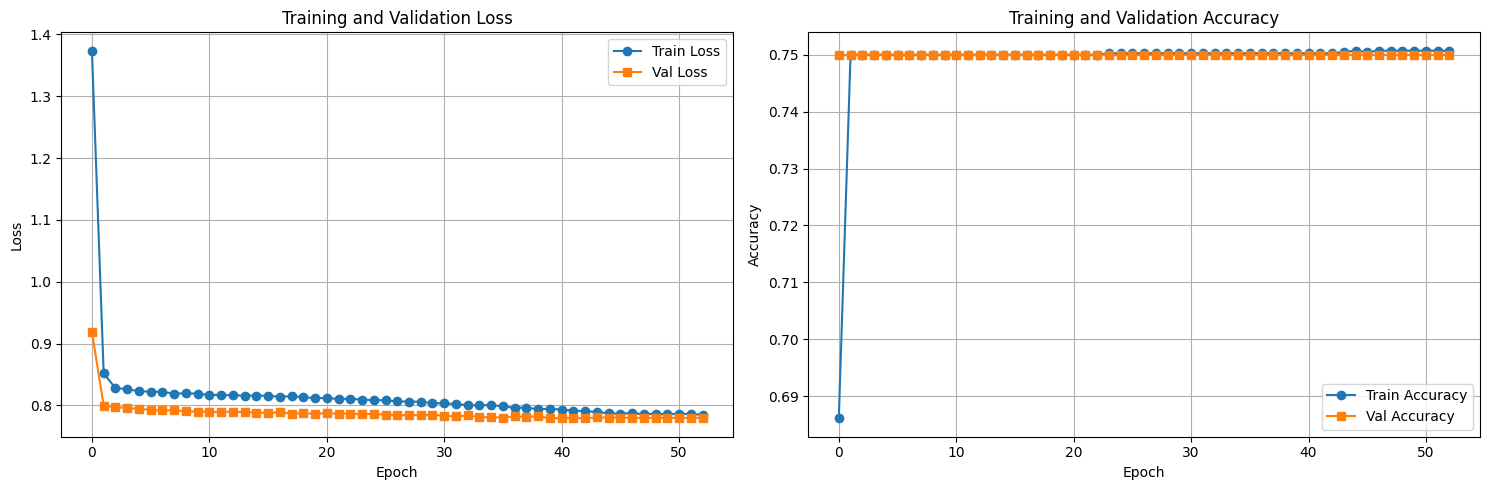

/tmp/ipykernel_15960/3934410387.py:140: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))


Loading best model from /workspace/MIL/output/models/ab_mil_autoencoder_128d_balanced_best_model.pt...


Evaluating Test Data: 100%|██████████| 12/12 [00:02<00:00,  4.60it/s]


Test Accuracy: 0.7507
Test AUC: 0.5357
Test Recall: 0.9991
Test Precision: 0.7509
Test F1-Score: 0.8574
ROC 곡선 저장: /workspace/MIL/output/figures/ab_mil_autoencoder_128d_balanced_roc_curve.png


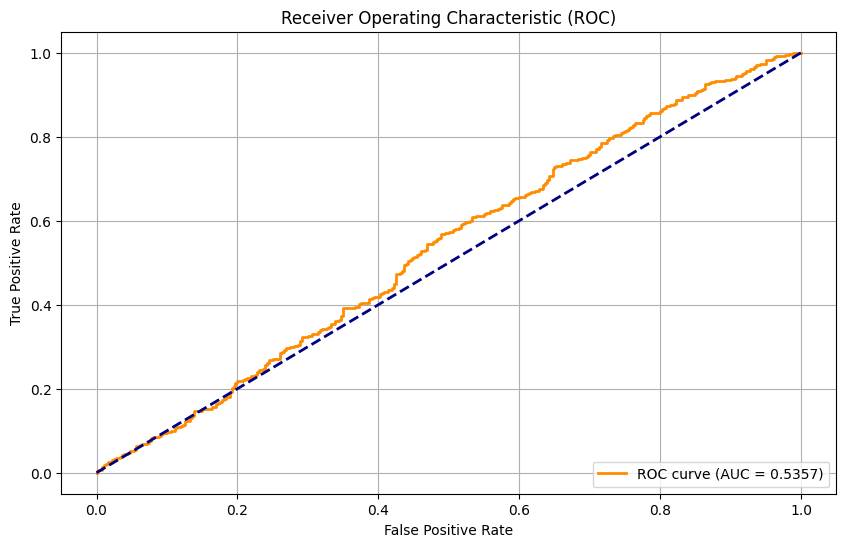

Logits 분포 저장: /workspace/MIL/output/figures/ab_mil_autoencoder_128d_balanced_logits_distribution.png


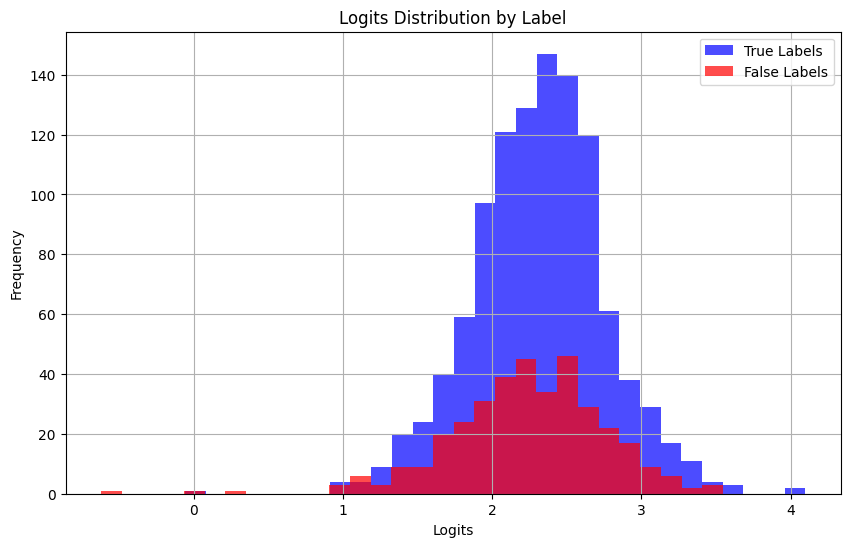

Confusion Matrix 저장: /workspace/MIL/output/figures/ab_mil_autoencoder_128d_balanced_confusion_matrix.png


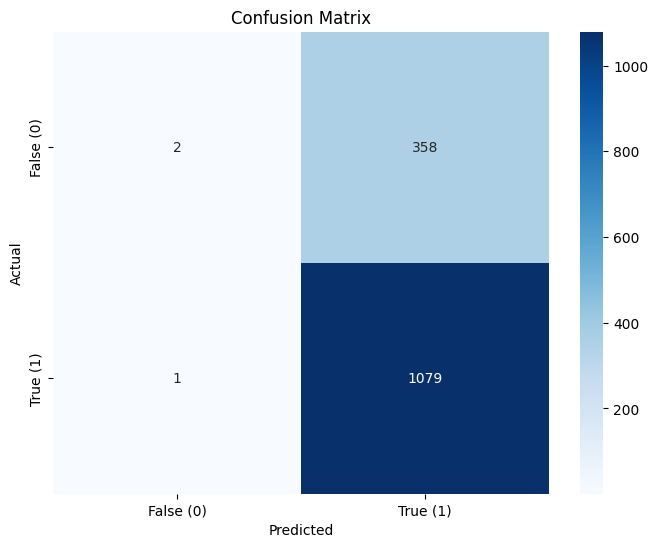

결과 저장: /workspace/MIL/output/results/ab_mil_autoencoder_128d_balanced_results.json


In [21]:
# 학습 과정 기록을 위한 리스트 초기화
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# 학습 곡선 시각화 함수
def plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies, save_dir=None):
    if save_dir is None:
        save_dir = "/workspace/MIL/output/figures"
    os.makedirs(save_dir, exist_ok=True)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss 곡선
    ax1.plot(train_losses, label='Train Loss', marker='o')
    ax1.plot(val_losses, label='Val Loss', marker='s')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Accuracy 곡선
    ax2.plot(train_accuracies, label='Train Accuracy', marker='o')
    ax2.plot(val_accuracies, label='Val Accuracy', marker='s')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    # 그래프 저장
    curves_path = os.path.join(save_dir, f"{model_name}_training_curves.png")
    plt.tight_layout()
    plt.savefig(curves_path, dpi=300, bbox_inches='tight')
    print(f"학습 곡선 저장: {curves_path}")
    plt.show()

# Optimizer와 Scheduler 정의
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',          # Validation Loss가 감소하지 않을 때 학습률 감소
    factor=0.1,          # 학습률 감소 비율
    patience=3,          # 몇 에폭 동안 개선되지 않으면 감소
    verbose=True         # 학습률 변경 시 출력
)

# 학습 시작 전 GPU 메모리 정리
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print(f"학습 시작 전 GPU 메모리: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB")

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    train_correct = 0
    train_total = 0
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]")
    
    for features, labels in train_loader_tqdm:
        features, labels = features.to(device), labels.to(device)
        
        # Mixed Precision Training
        with autocast():
            outputs, attention_weights = model(features)
            loss = criterion(outputs.squeeze(), labels)
        
        optimizer.zero_grad()
        
        # Gradient scaling for mixed precision
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        total_loss += loss.item()
        predictions = torch.round(torch.sigmoid(outputs)).squeeze()
        train_correct += (predictions == labels).sum().item()
        train_total += labels.size(0)
        
        # 메모리 사용량 모니터링 (10 배치마다)
        if train_loader_tqdm.n % 10 == 0:
            train_loader_tqdm.set_postfix({
                'loss': f'{loss.item():.4f}',
                'gpu_mem': f'{torch.cuda.memory_allocated(0) / 1024**3:.2f}GB'
            })
    
    train_accuracy = train_correct / train_total
    avg_train_loss = total_loss / len(train_loader)
    
    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        val_loader_tqdm = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]")
        for features, labels in val_loader_tqdm:
            features, labels = features.to(device), labels.to(device)
            
            with autocast():
                outputs, _ = model(features)
                loss = criterion(outputs.squeeze(), labels)
            
            val_loss += loss.item()
            predictions = torch.round(torch.sigmoid(outputs)).squeeze()
            val_correct += (predictions == labels).sum().item()
            val_total += labels.size(0)
    
    val_accuracy = val_correct / val_total
    avg_val_loss = val_loss / len(val_loader)
    
    # 학습 과정 기록
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, "
          f"Train Accuracy: {train_accuracy:.4f}, Val Loss: {avg_val_loss:.4f}, "
          f"Val Accuracy: {val_accuracy:.4f}")
    
    scheduler.step(avg_val_loss)  # Validation Loss를 기반으로 LR 감소
    early_stopping(avg_val_loss, model)
    
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break
    
    # 주기적으로 GPU 메모리 정리
    if epoch % 5 == 0:
        torch.cuda.empty_cache()

# 학습 곡선 그리기
plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies)

print(f"Loading best model from {save_path}...")
model.load_state_dict(torch.load(save_path))
test_metrics = evaluate_model(model, test_loader, device)

In [22]:
# 학습 과정 기록을 위한 리스트
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# 학습 곡선 시각화 함수
def plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies, save_dir=None):
    if save_dir is None:
        save_dir = "/workspace/MIL/output/figures"
    os.makedirs(save_dir, exist_ok=True)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss 곡선
    ax1.plot(train_losses, label='Train Loss', marker='o')
    ax1.plot(val_losses, label='Val Loss', marker='s')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Accuracy 곡선
    ax2.plot(train_accuracies, label='Train Accuracy', marker='o')
    ax2.plot(val_accuracies, label='Val Accuracy', marker='s')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    # 그래프 저장
    curves_path = os.path.join(save_dir, f"{model_name}_training_curves.png")
    plt.tight_layout()
    plt.savefig(curves_path, dpi=300, bbox_inches='tight')
    print(f"학습 곡선 저장: {curves_path}")
    plt.show()